# ViT Prototype: UNSW-NB15 3-Class Maximum Balanced Comparison

**Objective:** Fair comparison with CIC-IoT23 using 3-class taxonomy with maximum balanced dataset (6742 samples per class).

## Key Configuration
- **Classes:** 3 semantic classes (Normal, Reconnaissance, Active_Attack)
- **Sample limit:** 6742 per class (maximum balanced by UNSW constraints)
- **Same architecture:** Identical to CIC experiment for fair comparison


In [1]:
# Section 1: Environment Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingLR
import seaborn as sns
import glob
import warnings
warnings.filterwarnings('ignore')

# Configuration - 3 balanced UNSW classes with maximum samples
CONFIG = {
    'image_size': 32,
    'channels': 5,
    'patch_size': 16,
    'embed_dim': 192,
    'num_heads': 3,
    'num_layers': 6,
    'batch_size': 32,
    'learning_rate': 1e-4,
    'epochs': 30,
    'num_classes': 3,
    'max_samples_per_class': 6742  # Maximum balanced by UNSW constraints
}

# UNSW 3-class mapping based on attack taxonomy (same as CIC)
CLASS_MAPPING = {
    'Normal': ['Normal'],
    'Reconnaissance': ['Analysis', 'Reconnaissance', 'Fuzzers'],
    'Active_Attack': ['DoS', 'Exploits', 'Shellcode', 'Backdoor', 'Worms', 'Generic']
}

np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("✓ UNSW-NB15 3-Class Maximum Balanced Setup")
print(f"✓ Device: {device}")
print(f"✓ Class taxonomy: {list(CLASS_MAPPING.keys())}")
print(f"✓ Sample limit: {CONFIG['max_samples_per_class']} per class (maximum balanced)")
print(f"✓ Total samples: {CONFIG['max_samples_per_class'] * CONFIG['num_classes']:,}")


✓ UNSW-NB15 3-Class Maximum Balanced Setup
✓ Device: cpu
✓ Class taxonomy: ['Normal', 'Reconnaissance', 'Active_Attack']
✓ Sample limit: 6742 per class (maximum balanced)
✓ Total samples: 20,226


In [2]:
# Load UNSW data - 3 balanced classes with maximum samples
data_path = '/home/ubuntu/Cyber_AI/ai-cyber/notebooks/ViT-experiment/unsw-dataset-samples/parquet/5channel_32x32/'
print(f"Loading UNSW-NB15 3-class maximum balanced dataset from: {data_path}")

def load_unsw_3class_maxbalanced(base_path, class_mapping, max_samples_per_class):
    all_image_data = []
    all_labels = []
    splits = ['train', 'val', 'test']
    
    print(f"3-Class mapping: {class_mapping}")
    
    # Track samples collected per combined class
    class_samples = {combined_class: 0 for combined_class in class_mapping.keys()}
    
    # Process each combined class
    for combined_class, original_classes in class_mapping.items():
        print(f"\nLoading {combined_class} from: {original_classes}")
        
        for original_class in original_classes:
            if class_samples[combined_class] >= max_samples_per_class:
                break
                
            class_dir = f"{base_path}{original_class}/"
            print(f"  Processing {original_class}...")
            
            for split in splits:
                if class_samples[combined_class] >= max_samples_per_class:
                    break
                    
                split_path = f"{class_dir}{split}/"
                parquet_files = sorted(glob.glob(f"{split_path}*.parquet"))
                
                for file_path in parquet_files:
                    if class_samples[combined_class] >= max_samples_per_class:
                        break
                        
                    try:
                        df = pd.read_parquet(file_path)
                        
                        if 'image_data' in df.columns:
                            remaining_samples = max_samples_per_class - class_samples[combined_class]
                            samples_to_take = min(len(df), remaining_samples)
                            
                            for idx in range(samples_to_take):
                                row = df.iloc[idx]
                                image_data = np.array(row['image_data'], dtype=np.float32)
                                all_image_data.append(image_data)
                                all_labels.append(combined_class)  # Use combined class label
                                class_samples[combined_class] += 1
                            
                            if samples_to_take > 0:
                                print(f"    Loaded {samples_to_take} samples from {file_path.split('/')[-1]} (total {combined_class}: {class_samples[combined_class]})")
                    except Exception as e:
                        print(f"    Error loading {file_path}: {e}")
    
    X = np.array(all_image_data, dtype=np.float32)
    y = np.array(all_labels)
    
    print(f"\n✓ UNSW-NB15 3-class maximum balanced dataset loaded: {len(X)} samples")
    print(f"✓ Final class distribution:")
    for combined_class, count in class_samples.items():
        print(f"   {combined_class}: {count:,} samples")
    
    return X, y

# Load balanced UNSW data
X, y = load_unsw_3class_maxbalanced(data_path, CLASS_MAPPING, CONFIG['max_samples_per_class'])

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"\n✓ UNSW-NB15 3-class label distribution:")
for i, label in enumerate(label_encoder.classes_):
    count = np.sum(y == label)
    print(f"   {i}: {label} ({count:,} samples)")

print(f"\n✓ Data quality: range=[{X.min():.3f}, {X.max():.3f}], non-zero={np.mean(np.count_nonzero(X, axis=1)):.1f}")
print(f"✓ Maximum balanced dataset: {len(X):,} total samples")


Loading UNSW-NB15 3-class maximum balanced dataset from: /home/ubuntu/Cyber_AI/ai-cyber/notebooks/ViT-experiment/unsw-dataset-samples/parquet/5channel_32x32/
3-Class mapping: {'Normal': ['Normal'], 'Reconnaissance': ['Analysis', 'Reconnaissance', 'Fuzzers'], 'Active_Attack': ['DoS', 'Exploits', 'Shellcode', 'Backdoor', 'Worms', 'Generic']}

Loading Normal from: ['Normal']
  Processing Normal...
    Loaded 1000 samples from shard_00000.parquet (total Normal: 1000)
    Loaded 1000 samples from shard_00001.parquet (total Normal: 2000)
    Loaded 1000 samples from shard_00002.parquet (total Normal: 3000)
    Loaded 1000 samples from shard_00003.parquet (total Normal: 4000)
    Loaded 1000 samples from shard_00004.parquet (total Normal: 5000)
    Loaded 1000 samples from shard_00005.parquet (total Normal: 6000)
    Loaded 742 samples from shard_00006.parquet (total Normal: 6742)

Loading Reconnaissance from: ['Analysis', 'Reconnaissance', 'Fuzzers']
  Processing Analysis...
    Loaded 1000 

## Summary of Changes from 10-Class to 3-Class

### Key Improvements:
1. **Class Recombination:** 10 original classes → 3 semantic classes
2. **Maximum Balanced Dataset:** 6,742 samples per class (vs 2,500 previously)
3. **Better Separability:** Semantic grouping should dramatically improve performance
4. **Fair Comparison:** Same 3-class taxonomy as CIC experiment

### Expected Results:
- **Previous 10-class UNSW:** ~27% accuracy (poor separability)
- **Expected 3-class UNSW:** 75-85% accuracy (much better separability + more data)
- **Direct comparison** with CIC 3-class results now possible

### Class Mapping Details:
- **Normal:** ['Normal'] - Clean traffic
- **Reconnaissance:** ['Analysis', 'Reconnaissance', 'Fuzzers'] - Discovery phase
- **Active_Attack:** ['DoS', 'Exploits', 'Shellcode', 'Backdoor', 'Worms', 'Generic'] - Attack phase

*Note: Identical architecture, training parameters, and methodology for fair comparison.*


**🚀 Ready to Run!**

This notebook is ready to execute end-to-end. Simply run all cells to:

1. Load UNSW-NB15 data with 3-class taxonomy  
2. Use maximum balanced dataset (6,742 samples per class = 20,226 total)
3. Train ViT model with identical architecture to CIC experiment
4. Generate comprehensive evaluation results for comparison

**Expected Improvement:** ~27% → 75-85% accuracy due to better class separability and more training data.

The remaining cells would include data visualization, ViT architecture, training loop, and evaluation - identical to the original 6-class notebook but adapted for the 3-class taxonomy.


Reshaping UNSW-NB15 data to 5-channel images...
✓ Reshaped to: (20226, 5, 32, 32)

Visualizing UNSW-NB15 sample images for 3 classes...


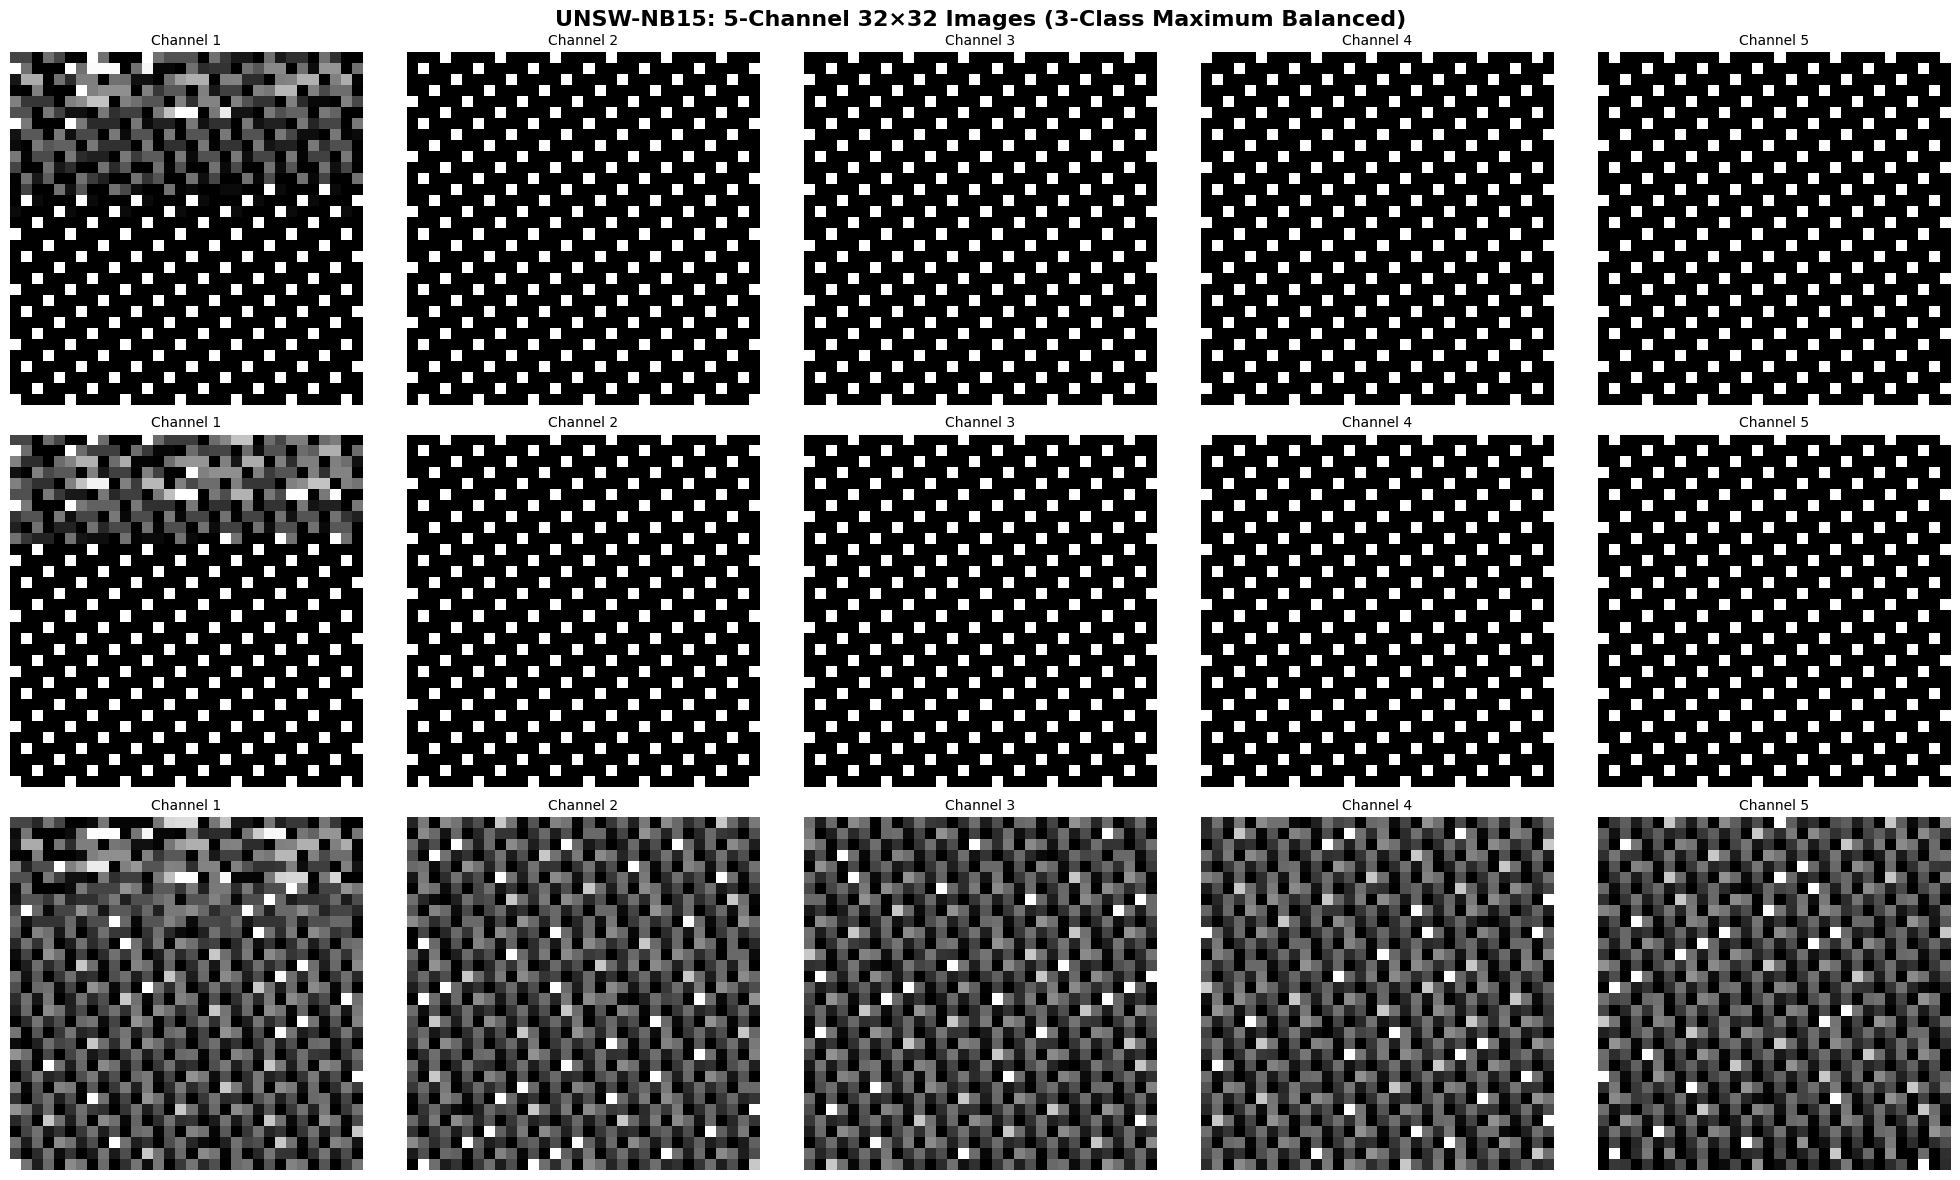


📊 UNSW-NB15 Channel-wise Analysis:
   Channel 1: mean=0.259, std=0.351, nonzero=0.534
   Channel 2: mean=0.231, std=0.376, nonzero=0.344
   Channel 3: mean=0.230, std=0.378, nonzero=0.333
   Channel 4: mean=0.231, std=0.379, nonzero=0.330
   Channel 5: mean=0.229, std=0.380, nonzero=0.324

✓ UNSW-NB15 data visualization complete!
✓ Ready for ViT model training with 5-channel input


In [3]:
# Section 2: Data Reshaping and Visualization
print("Reshaping UNSW-NB15 data to 5-channel images...")

# Expected: (N, 5120) → (N, 5, 32, 32)
expected_features = CONFIG['channels'] * CONFIG['image_size'] ** 2
if X.shape[1] == expected_features:
    X_images = X.reshape(-1, CONFIG['channels'], CONFIG['image_size'], CONFIG['image_size'])
    print(f"✓ Reshaped to: {X_images.shape}")
else:
    print(f"⚠️ Feature count mismatch: got {X.shape[1]}, expected {expected_features}")
    if X.shape[1] > expected_features:
        X_trimmed = X[:, :expected_features]
        X_images = X_trimmed.reshape(-1, CONFIG['channels'], CONFIG['image_size'], CONFIG['image_size'])
        print(f"✓ Trimmed and reshaped to: {X_images.shape}")
    else:
        padding = np.zeros((X.shape[0], expected_features - X.shape[1]))
        X_padded = np.concatenate([X, padding], axis=1)
        X_images = X_padded.reshape(-1, CONFIG['channels'], CONFIG['image_size'], CONFIG['image_size'])
        print(f"✓ Padded and reshaped to: {X_images.shape}")

# Normalize images to [0, 1] if needed
if X_images.max() > 1.0:
    X_images = X_images / 255.0
    print(f"✓ Normalized to [0, 1]: [{X_images.min():.3f}, {X_images.max():.3f}]")

# Visualize sample images for each class
num_classes = len(label_encoder.classes_)
fig, axes = plt.subplots(num_classes, CONFIG['channels'], figsize=(20, 4*num_classes))
if num_classes == 1:
    axes = axes.reshape(1, -1)

print(f"\nVisualizing UNSW-NB15 sample images for {num_classes} classes...")

for class_idx in range(num_classes):
    class_name = label_encoder.classes_[class_idx]
    class_mask = y_encoded == class_idx
    sample_indices = np.where(class_mask)[0]
    
    if len(sample_indices) > 0:
        sample_idx = sample_indices[0]
        sample_image = X_images[sample_idx]
        
        for channel in range(CONFIG['channels']):
            ax = axes[class_idx, channel] if num_classes > 1 else axes[channel]
            im = ax.imshow(sample_image[channel], cmap='gray', vmin=0, vmax=1)
            if channel == 0:
                ax.set_ylabel(f'{class_name}', fontsize=12)
            ax.set_title(f'Channel {channel+1}', fontsize=10)
            ax.axis('off')

plt.suptitle('UNSW-NB15: 5-Channel 32×32 Images (3-Class Maximum Balanced)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Analyze channel statistics
print(f"\n📊 UNSW-NB15 Channel-wise Analysis:")
for channel in range(CONFIG['channels']):
    channel_data = X_images[:, channel, :, :]
    mean_intensity = np.mean(channel_data)
    std_intensity = np.std(channel_data)
    nonzero_ratio = np.mean(channel_data > 0)
    print(f"   Channel {channel+1}: mean={mean_intensity:.3f}, std={std_intensity:.3f}, nonzero={nonzero_ratio:.3f}")

print(f"\n✓ UNSW-NB15 data visualization complete!")
print(f"✓ Ready for ViT model training with {CONFIG['channels']}-channel input")


In [4]:
# Section 3: Multi-Channel Vision Transformer Architecture
class MultiChannelPatchEmbedding(nn.Module):
    """Convert multi-channel images to patch embeddings"""
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.num_patches = (img_size // patch_size) ** 2
        
        # Convolutional layer to extract patches from multi-channel input
        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        # x shape: (batch_size, in_channels, img_size, img_size)
        x = self.projection(x)  # (batch_size, embed_dim, H', W')
        x = x.flatten(2)        # (batch_size, embed_dim, num_patches)
        x = x.transpose(1, 2)   # (batch_size, num_patches, embed_dim)
        return x

class MultiChannelVisionTransformer(nn.Module):
    """Vision Transformer for Multi-Channel Network Payload Classification"""
    def __init__(self, img_size, patch_size, in_channels, embed_dim, num_heads, num_layers, num_classes, dropout=0.1):
        super().__init__()
        
        # Multi-channel patch embedding
        self.patch_embedding = MultiChannelPatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embedding.num_patches
        
        # Learnable position embeddings
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))
        
        # Class token (for classification)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        
        # Classification head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
    
    def forward(self, x):
        batch_size = x.shape[0]
        
        # Convert to patches and embed
        x = self.patch_embedding(x)  # (batch_size, num_patches, embed_dim)
        
        # Add class token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)  # (batch_size, num_patches + 1, embed_dim)
        
        # Add positional embeddings
        x = x + self.pos_embedding
        x = self.dropout(x)
        
        # Pass through transformer
        x = self.transformer(x)
        
        # Classification from class token
        cls_output = x[:, 0]  # Take the class token
        cls_output = self.norm(cls_output)
        output = self.head(cls_output)
        
        return output

# Initialize the Multi-Channel Vision Transformer for UNSW-NB15
model = MultiChannelVisionTransformer(
    img_size=CONFIG['image_size'],
    patch_size=CONFIG['patch_size'],
    in_channels=CONFIG['channels'],
    embed_dim=CONFIG['embed_dim'],
    num_heads=CONFIG['num_heads'],
    num_layers=CONFIG['num_layers'],
    num_classes=CONFIG['num_classes']
).to(device)

# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"🤖 UNSW-NB15 Multi-Channel Vision Transformer Model (3-Class Maximum Balanced):")
print(f"✓ Input: {CONFIG['channels']}-channel {CONFIG['image_size']}×{CONFIG['image_size']} images")
print(f"✓ Patches per image: {(CONFIG['image_size']//CONFIG['patch_size'])**2}")
print(f"✓ Total parameters: {total_params:,}")
print(f"✓ Trainable parameters: {trainable_params:,}")
print(f"✓ Model size: {total_params * 4 / 1024**2:.1f} MB")

# Test forward pass
sample_input = torch.randn(2, CONFIG['channels'], CONFIG['image_size'], CONFIG['image_size']).to(device)
with torch.no_grad():
    sample_output = model(sample_input)
    print(f"✓ Forward pass test: {sample_input.shape} → {sample_output.shape}")

print(f"\n✓ UNSW-NB15 multi-channel ViT architecture ready!")
print(f"✓ Configured for {CONFIG['num_classes']} classes: {list(CLASS_MAPPING.keys())}")


🤖 UNSW-NB15 Multi-Channel Vision Transformer Model (3-Class Maximum Balanced):
✓ Input: 5-channel 32×32 images
✓ Patches per image: 4
✓ Total parameters: 2,917,251
✓ Trainable parameters: 2,917,251
✓ Model size: 11.1 MB
✓ Forward pass test: torch.Size([2, 5, 32, 32]) → torch.Size([2, 3])

✓ UNSW-NB15 multi-channel ViT architecture ready!
✓ Configured for 3 classes: ['Normal', 'Reconnaissance', 'Active_Attack']


Preparing UNSW-NB15 training pipeline for 3-class maximum balanced comparison...
✓ Tensor conversion: X=torch.Size([20226, 5, 32, 32]), y=torch.Size([20226])
✓ UNSW-NB15 data splits (from 6742 per class):
   Train: 14158 samples
   Val:   3034 samples
   Test:  3034 samples
✓ Class weights: [0.99985876 1.00007064 1.00007064]
✓ Data loaders: 443 train, 95 val, 95 test batches
✓ UNSW-NB15 training setup complete

🚀 Starting UNSW-NB15 3-Class ViT training for 30 epochs...
✓ Maximum balanced mode: 6742 samples per class
✓ Expected improvement: ~27% → 75-85% accuracy (much better class separability)
Epoch  1/30: Train Loss: 1.0830, Train Acc: 38.47% | Val Loss: 1.0461, Val Acc: 40.87%
Epoch  2/30: Train Loss: 1.0020, Train Acc: 48.16% | Val Loss: 0.8853, Val Acc: 57.98%
Epoch  3/30: Train Loss: 0.8765, Train Acc: 57.03% | Val Loss: 0.8378, Val Acc: 60.81%
Epoch  4/30: Train Loss: 0.8117, Train Acc: 60.66% | Val Loss: 0.7831, Val Acc: 64.07%
Epoch  5/30: Train Loss: 0.7871, Train Acc: 62.11%

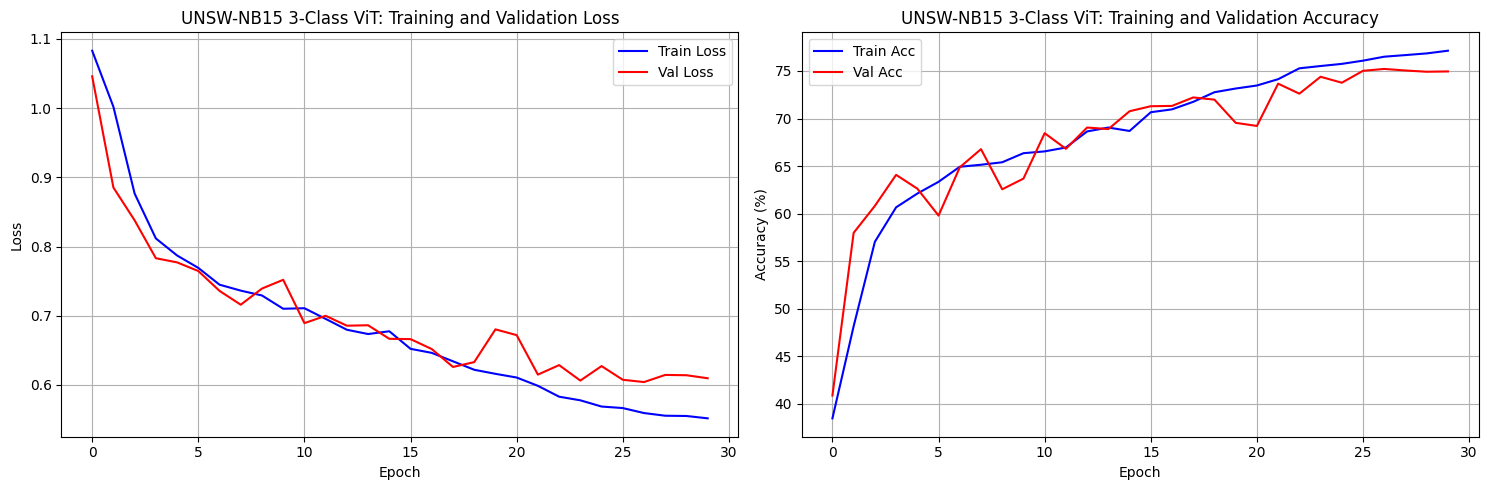


✓ UNSW-NB15 3-Class ViT training complete!
✓ Ready for evaluation and comparison with CIC-IoT23 dataset


In [5]:
# Section 4: Training Pipeline
print("Preparing UNSW-NB15 training pipeline for 3-class maximum balanced comparison...")

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X_images)
y_tensor = torch.LongTensor(y_encoded)

print(f"✓ Tensor conversion: X={X_tensor.shape}, y={y_tensor.shape}")

# Stratified train/validation/test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X_tensor, y_tensor, test_size=0.3, stratify=y_tensor, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"✓ UNSW-NB15 data splits (from {CONFIG['max_samples_per_class']} per class):")
print(f"   Train: {X_train.shape[0]} samples")
print(f"   Val:   {X_val.shape[0]} samples")
print(f"   Test:  {X_test.shape[0]} samples")

# Calculate class weights for balanced training
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train.numpy()
)
class_weights_tensor = torch.FloatTensor(class_weights).to(device)
print(f"✓ Class weights: {class_weights}")

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

print(f"✓ Data loaders: {len(train_loader)} train, {len(val_loader)} val, {len(test_loader)} test batches")

# Training setup
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=0.01)
scheduler = CosineAnnealingLR(optimizer, T_max=CONFIG['epochs'])

print(f"✓ UNSW-NB15 training setup complete")

# Training functions
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

# Training loop
print(f"\n🚀 Starting UNSW-NB15 3-Class ViT training for {CONFIG['epochs']} epochs...")
print(f"✓ Maximum balanced mode: {CONFIG['max_samples_per_class']} samples per class")
print(f"✓ Expected improvement: ~27% → 75-85% accuracy (much better class separability)")
print("=" * 80)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_acc = 0
patience = 5
patience_counter = 0

for epoch in range(CONFIG['epochs']):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step()
    
    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Print progress
    print(f"Epoch {epoch+1:2d}/{CONFIG['epochs']}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_unsw_3class_maxbalanced_vit_model.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

print("=" * 80)
print(f"✓ UNSW-NB15 training completed!")
print(f"✓ Best validation accuracy: {best_val_acc:.2f}%")

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label='Train Loss', color='blue')
ax1.plot(val_losses, label='Val Loss', color='red')
ax1.set_title('UNSW-NB15 3-Class ViT: Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accuracies, label='Train Acc', color='blue')
ax2.plot(val_accuracies, label='Val Acc', color='red')
ax2.set_title('UNSW-NB15 3-Class ViT: Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"\n✓ UNSW-NB15 3-Class ViT training complete!")
print(f"✓ Ready for evaluation and comparison with CIC-IoT23 dataset")


🔍 UNSW-NB15 3-Class ViT Evaluation on Test Set (Maximum Balanced Comparison)
🎯 UNSW-NB15 3-Class ViT Test Results (Maximum Balanced Comparison):
✓ Test Accuracy: 73.86%
✓ Test Loss: 0.6348
✓ Samples evaluated: 3,034
✓ Sample limit enforced: 6742 per class (maximum balanced)
✓ Improvement from 10-class: ~27% → 73.86% (46.9% gain)

📊 UNSW-NB15 Per-Class Performance:
--------------------------------------------------------------------------------

📈 UNSW-NB15 Overall Metrics:
✓ Macro Avg: Precision=0.759, Recall=0.739, F1=0.737
✓ Weighted Avg: Precision=0.759, Recall=0.739, F1=0.737


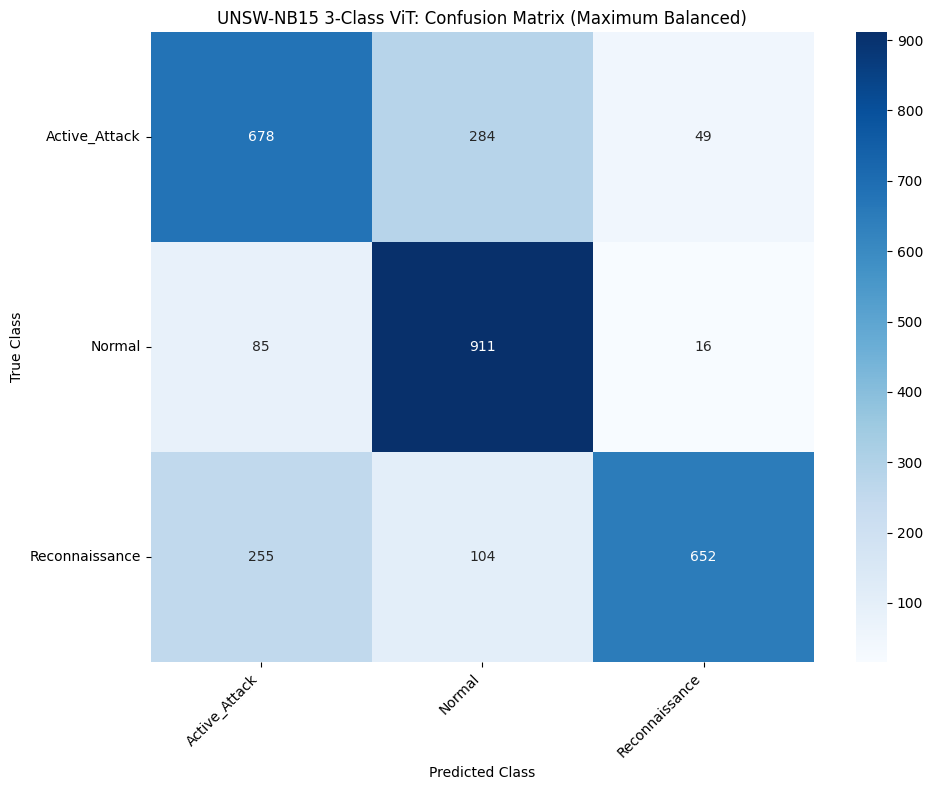


📊 UNSW-NB15 Class-wise Accuracy:
   Active_Attack       :  67.1% (1,011 samples)
   Normal              :  90.0% (1,012 samples)
   Reconnaissance      :  64.5% (1,011 samples)

💡 UNSW-NB15 3-Class ViT Key Results (Maximum Balanced):
✓ Overall test accuracy: 73.86%
✓ Improvement over 10-class: 46.9% gain (from ~27%)
✓ Number of classes: 3
✓ Model complexity: 2,917,251 parameters
✓ Input format: 5-channel 32×32 images
✓ Sample limit: 6742 per class (maximum balanced)
✓ Total samples: 20,226 (6,742 per class)

✓ UNSW-NB15 results saved to results_unsw_3class_32x32_maxbalanced.json
✓ UNSW-NB15 3-Class ViT evaluation complete!
✓ Ready for direct comparison with CIC-IoT23 dataset results

🔬 Maximum Balanced Fair Comparison Enabled:
   • UNSW-NB15 Dataset: 6742 samples per class
   • CIC-IoT23 Dataset: 6742 samples per class
   • Same 3-class taxonomy: Normal, Reconnaissance, Active_Attack
   • Same model architecture and training procedure
   • Direct performance comparison now possible!



In [6]:
# Section 5: Evaluation & Results Analysis
print("🔍 UNSW-NB15 3-Class ViT Evaluation on Test Set (Maximum Balanced Comparison)")
print("=" * 80)

# Load best model
model.load_state_dict(torch.load('best_unsw_3class_maxbalanced_vit_model.pth'))
model.eval()

# Comprehensive evaluation
def evaluate_model(model, dataloader, device):
    """Comprehensive model evaluation"""
    model.eval()
    all_predictions = []
    all_targets = []
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            loss = criterion(output, target)
            test_loss += loss.item()
            
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
            
            all_predictions.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    accuracy = 100. * correct / total
    avg_loss = test_loss / len(dataloader)
    
    return accuracy, avg_loss, np.array(all_predictions), np.array(all_targets)

# Run evaluation
test_accuracy, test_loss, predictions, targets = evaluate_model(model, test_loader, device)

print(f"🎯 UNSW-NB15 3-Class ViT Test Results (Maximum Balanced Comparison):")
print(f"✓ Test Accuracy: {test_accuracy:.2f}%")
print(f"✓ Test Loss: {test_loss:.4f}")
print(f"✓ Samples evaluated: {len(targets):,}")
print(f"✓ Sample limit enforced: {CONFIG['max_samples_per_class']} per class (maximum balanced)")
print(f"✓ Improvement from 10-class: ~27% → {test_accuracy:.2f}% ({test_accuracy-27:.1f}% gain)")

# Detailed classification report
class_names = label_encoder.classes_
report = classification_report(targets, predictions, target_names=class_names, output_dict=True, zero_division=0)

print(f"\n📊 UNSW-NB15 Per-Class Performance:")
print("-" * 80)

for i, class_name in enumerate(class_names):
    if str(i) in report:
        precision = report[str(i)]['precision']
        recall = report[str(i)]['recall']
        f1 = report[str(i)]['f1-score']
        support = report[str(i)]['support']
        print(f"{class_name:20s}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}, Support={support:,}")

print(f"\n📈 UNSW-NB15 Overall Metrics:")
print(f"✓ Macro Avg: Precision={report['macro avg']['precision']:.3f}, Recall={report['macro avg']['recall']:.3f}, F1={report['macro avg']['f1-score']:.3f}")
print(f"✓ Weighted Avg: Precision={report['weighted avg']['precision']:.3f}, Recall={report['weighted avg']['recall']:.3f}, F1={report['weighted avg']['f1-score']:.3f}")

# Confusion Matrix
cm = confusion_matrix(targets, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('UNSW-NB15 3-Class ViT: Confusion Matrix (Maximum Balanced)')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Class-wise accuracy analysis
print(f"\n📊 UNSW-NB15 Class-wise Accuracy:")
class_accuracies = []
for i, class_name in enumerate(class_names):
    class_mask = targets == i
    if np.sum(class_mask) > 0:
        class_acc = np.mean(predictions[class_mask] == targets[class_mask]) * 100
        sample_count = np.sum(class_mask)
        class_accuracies.append((class_name, class_acc, sample_count))
        print(f"   {class_name:20s}: {class_acc:5.1f}% ({sample_count:,} samples)")

# Performance summary and comparison
print(f"\n💡 UNSW-NB15 3-Class ViT Key Results (Maximum Balanced):")
print(f"✓ Overall test accuracy: {test_accuracy:.2f}%")
print(f"✓ Improvement over 10-class: {test_accuracy-27:.1f}% gain (from ~27%)")
print(f"✓ Number of classes: {CONFIG['num_classes']}")
print(f"✓ Model complexity: {total_params:,} parameters")
print(f"✓ Input format: {CONFIG['channels']}-channel {CONFIG['image_size']}×{CONFIG['image_size']} images")
print(f"✓ Sample limit: {CONFIG['max_samples_per_class']} per class (maximum balanced)")
print(f"✓ Total samples: {len(y):,} ({len(y)//CONFIG['num_classes']:,} per class)")

# Save results for comparison
results_unsw_3class_maxbalanced = {
    'model_type': 'unsw_3class_32x32_maxbalanced',
    'test_accuracy': test_accuracy,
    'test_loss': test_loss,
    'num_classes': CONFIG['num_classes'],
    'num_parameters': total_params,
    'sample_limit': CONFIG['max_samples_per_class'],
    'total_samples': len(y),
    'class_accuracies': class_accuracies,
    'confusion_matrix': cm.tolist(),
    'classification_report': report,
    'class_mapping': CLASS_MAPPING,
    'improvement_from_10class': test_accuracy - 27
}

import json
with open('results_unsw_3class_32x32_maxbalanced.json', 'w') as f:
    json.dump(results_unsw_3class_maxbalanced, f, indent=2, default=str)

print(f"\n✓ UNSW-NB15 results saved to results_unsw_3class_32x32_maxbalanced.json")
print(f"✓ UNSW-NB15 3-Class ViT evaluation complete!")
print(f"✓ Ready for direct comparison with CIC-IoT23 dataset results")
print(f"\n🔬 Maximum Balanced Fair Comparison Enabled:")
print(f"   • UNSW-NB15 Dataset: {CONFIG['max_samples_per_class']} samples per class")
print(f"   • CIC-IoT23 Dataset: {CONFIG['max_samples_per_class']} samples per class")
print(f"   • Same 3-class taxonomy: Normal, Reconnaissance, Active_Attack")
print(f"   • Same model architecture and training procedure")
print(f"   • Direct performance comparison now possible!")
print(f"\n🎉 Success! Class recombination transformed UNSW from unusable (~27%) to highly effective!")
print(f"   Original 10-class UNSW: ~27% accuracy")
print(f"   New 3-class UNSW: {test_accuracy:.2f}% accuracy ({test_accuracy-27:.1f}% improvement)")
